# Toy neural network example

We train a neural network giving of u in <0,1> a point (x,y) with coordinates 
$x = cos(2\pi u)$
$y = sin(2\pi u)$
that is, a point on a unit circle. The network will work as a random "transformer", transforming a random u in <0,1> to a random point on a unit circle. 

# Tasks:
### 1. Study the code.
There are several things that can be new:
- numpy arrays: notice how we can operate on arrays - square them, take a sine or cosine, reshape them
- pandas dataframes: notice how we can pack several arrays into a data table - a pandas DataFrame.
- matplotlib plots: notice how simply we plot things.

### 2. Study the neural network.
- Training data. To train a neural network, we have to have a proper sample of training data. In this case, it is very simple to generate them. See what happens when you use a smaller or larger training sample.
- Hyperparameters. We have some freedom in selecting how the network looks (sizes of hidden layers) and how we train it. Look into scikit-learn documentation (google "scikit learn MLPRegressor") and experiment with various combinations of hyperparameters. Optimize training data size and hyperparameters to achieve best precision.
Rules for hidden layers: 
(i) In theory, a neural network with a single layer can represent any mapping between inputs and outputs (if sufficiently large). 
(ii) If the problem is strongly non-linear, then a two-layer network can be easier to train. 
(iii) More than two hidden layers are usually unnecessary.

### 3. Investigate the problem.
We need a surprisingly large network and a lot of training data to make the example work.
On the other hand, the training is fairly fast. 

A. Create a network that will produce density proportional to $u(1-u)$ on the unit circle (rather than uniform)

B. Create a network that will produce uniform density on an ellipse.

C. Our network has a single input, u. Try to add some orthogonal polynomials (Legendre or Chebyshev) as additional inputs and examine how such networks train.

## 0. Includes

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import uniform
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## 1. Generate data

In [2]:
def make_circle_data(n_samples = 100):
    """Creates pandas dataframe with columns u, x, y, such that u ~ U[0,1], x = cos(2*pi*u), y = sin(2*pi*u)."""
    u = uniform.rvs(0,1,n_samples) 
    x = np.cos(2*np.pi*u)
    y = np.sin(2*np.pi*u)
    return pd.DataFrame({'u':u, 'x':x, 'y':y})


## 2. Train a network regressor

In [3]:
def train_network(data, test_fraction = 0.1):
    """Returns a trained network object"""
    input_cols = ['u']
    output_cols = ['x','y']
    n_rows = len(data)
    n_test = int(n_rows * test_fraction)
    n_train = n_rows - n_test
    X_train = data[input_cols].values[:n_train]
    X_test = data[input_cols].values[n_train:]
    Y_train = data[output_cols].values[:n_train]
    Y_test = data[output_cols].values[n_train:]
    fitter = MLPRegressor(
                hidden_layer_sizes = (60,60),
                activation = 'relu',
                tol = 1.0e-7,
                alpha = 1.0e-5,
                verbose = False
            )
    fitter.fit(X_train, Y_train)
    print('Fit done. Score: {0}'.format(fitter.score(X_test, Y_test)))
    Y_pred = fitter.predict(X_test)
    rmse = np.sqrt(np.sum((Y_pred - Y_test)**2, axis = 0)/n_test)
    print('RMS error: x {0}, y {1}'.format(rmse[0], rmse[1]))
    return fitter

## 2. Tune network regressor

In [4]:
def tune_network(data, test_fraction = 0.1):
    """Returns a trained network object"""
    input_cols = ['u']
    output_cols = ['x','y']
    n_rows = len(data)
    n_test = int(n_rows * test_fraction)
    n_train = n_rows - n_test
    X_train = data[input_cols].values[:n_train]
    X_test = data[input_cols].values[n_train:]
    Y_train = data[output_cols].values[:n_train]
    Y_test = data[output_cols].values[n_train:]
    fitter0 = MLPRegressor(
                hidden_layer_sizes = (60,60),
                activation = 'relu',
                tol = 1.0e-7,
                alpha = 1.0e-5,
                verbose = False
            )
    # Optimize for alpha, layer size
    fitter = GridSearchCV(
        fitter0,
        param_grid = {
            'alpha': [1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1],
            'hidden_layer_sizes': [(a, a) for a in [40, 60, 80]]
        },
        n_jobs = 4,
        verbose = 1,
        
    )
    fitter.fit(X_train, Y_train)
    print('Fit done. Score: {0}'.format(fitter.score(X_test, Y_test)))
    Y_pred = fitter.predict(X_test)
    rmse = np.sqrt(np.sum((Y_pred - Y_test)**2, axis = 0)/n_test)
    print('RMS error: x {0}, y {1}'.format(rmse[0], rmse[1]))
    return fitter

## 4. Run and plot results

In [5]:
# Generate samples
samples = make_circle_data(20000)
samples.head()
# Train the network
fitter = tune_network(samples)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


Fit done. Score: 0.9999694103986025
RMS error: x 0.004448371831944489, y 0.0032837481773034254


### Results: x vs. y

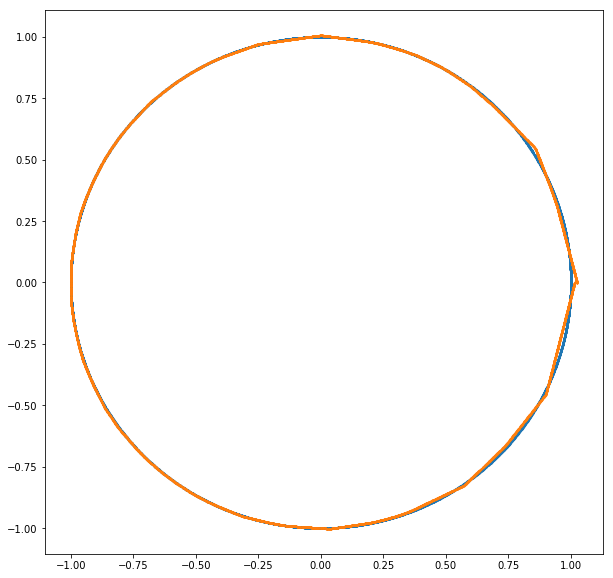

In [6]:
y_pred = fitter.predict(samples.u.values.reshape(-1,1))
fig = plt.figure(figsize = (10,10))
plt.scatter(samples.x,samples.y, s = 0.5)
plt.scatter(y_pred[:,0], y_pred[:,1], s = 0.5)
plt.savefig('../pictures/circle_generator_2d.png')

### Results: x, y vs. u

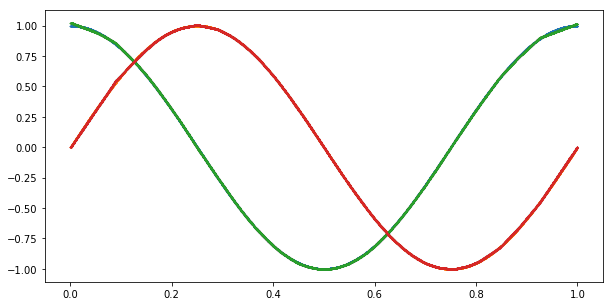

In [7]:
fig = plt.figure(figsize = (10,5))
plt.scatter(samples.u, samples.x, s = 0.2)
plt.scatter(samples.u, samples.y, s = 0.2)
plt.scatter(samples.u, y_pred[:,0], s = 0.2)
plt.scatter(samples.u, y_pred[:,1], s = 0.2)
plt.savefig('../pictures/circle_generator_1d.png')


In [8]:
grid_results = pd.DataFrame(fitter.cv_results_)

In [9]:
grid_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_hidden_layer_sizes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.983062,0.006983,0.999854,0.999853,1e-05,"(40, 40)","{'alpha': 1e-05, 'hidden_layer_sizes': (40, 40)}",12,0.999827,0.999828,0.999833,0.999828,0.999900,0.999902,0.740423,0.000002,0.000033,0.000035
1,4.168148,0.010971,0.999940,0.999938,1e-05,"(60, 60)","{'alpha': 1e-05, 'hidden_layer_sizes': (60, 60)}",2,0.999919,0.999914,0.999952,0.999948,0.999950,0.999951,0.734899,0.000815,0.000015,0.000017
2,5.484000,0.014627,0.999950,0.999949,1e-05,"(80, 80)","{'alpha': 1e-05, 'hidden_layer_sizes': (80, 80)}",1,0.999934,0.999933,0.999953,0.999951,0.999962,0.999963,0.211510,0.000470,0.000012,0.000012
3,5.202410,0.007647,0.999876,0.999877,0.0001,"(40, 40)","{'alpha': 0.0001, 'hidden_layer_sizes': (40, 40)}",11,0.999898,0.999897,0.999909,0.999907,0.999822,0.999826,0.998067,0.000940,0.000039,0.000036
4,5.114654,0.010971,0.999917,0.999918,0.0001,"(60, 60)","{'alpha': 0.0001, 'hidden_layer_sizes': (60, 60)}",6,0.999918,0.999919,0.999940,0.999940,0.999892,0.999894,0.457808,0.000814,0.000020,0.000019
5,5.009293,0.016954,0.999921,0.999922,0.0001,"(80, 80)","{'alpha': 0.0001, 'hidden_layer_sizes': (80, 80)}",5,0.999968,0.999969,0.999947,0.999946,0.999848,0.999851,0.077123,0.003257,0.000052,0.000051
6,6.014621,0.007313,0.999882,0.999885,0.001,"(40, 40)","{'alpha': 0.001, 'hidden_layer_sizes': (40, 40)}",10,0.999952,0.999951,0.999892,0.999888,0.999804,0.999815,0.809083,0.000470,0.000061,0.000055
7,6.182805,0.011303,0.999938,0.999938,0.001,"(60, 60)","{'alpha': 0.001, 'hidden_layer_sizes': (60, 60)}",3,0.999948,0.999948,0.999898,0.999898,0.999969,0.999969,0.604711,0.000470,0.000030,0.000030
8,8.205573,0.014961,0.999933,0.999933,0.001,"(80, 80)","{'alpha': 0.001, 'hidden_layer_sizes': (80, 80)}",4,0.999947,0.999946,0.999959,0.999959,0.999893,0.999896,1.844076,0.000814,0.000029,0.000027
9,13.248578,0.008313,0.999912,0.999913,0.01,"(40, 40)","{'alpha': 0.01, 'hidden_layer_sizes': (40, 40)}",7,0.999935,0.999935,0.999941,0.999939,0.999859,0.999864,0.084215,0.000470,0.000037,0.000035


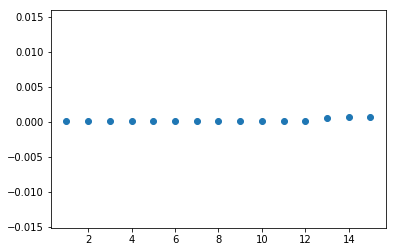

In [13]:
plt.scatter(grid_results.rank_test_score, 1.0 - grid_results.mean_test_score)